# Bluebook for Bulldozers

## Preprocessing and Training

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.decomposition import PCA # not yet using
# from sklearn.preprocessing import scale # not yet using
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, learning_curve, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import Lasso
from bayes_opt import BayesianOptimization
from tpot import TPOTRegressor
from sklearn import preprocessing
from joblib import dump, load

/Users/gregmckenzie/anaconda3/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.3.0.


In [3]:
df = pd.read_csv(
    '../data/processed/exploratory-data-analysis.csv',
    low_memory=False
)

### Converting strings into categories

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372915 entries, 0 to 372914
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   372915 non-null  int64  
 1   SalePrice                 372915 non-null  float64
 2   MachineID                 372915 non-null  int64  
 3   ModelID                   372915 non-null  int64  
 4   datasource                372915 non-null  int64  
 5   auctioneerID              355456 non-null  float64
 6   YearMade                  372915 non-null  int64  
 7   MachineHoursCurrentMeter  130277 non-null  float64
 8   UsageBand                 68017 non-null   object 
 9   fiModelDesc               372915 non-null  object 
 10  fiBaseModel               372915 non-null  object 
 11  fiSecondaryDesc           250059 non-null  object 
 12  fiModelSeries             49026 non-null   object 
 13  fiModelDescriptor         70124 non-null   o

In [5]:
#  find the columns that contain strings, and turn them into categories
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype("category").cat.as_ordered()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372915 entries, 0 to 372914
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   372915 non-null  int64   
 1   SalePrice                 372915 non-null  float64 
 2   MachineID                 372915 non-null  int64   
 3   ModelID                   372915 non-null  int64   
 4   datasource                372915 non-null  int64   
 5   auctioneerID              355456 non-null  float64 
 6   YearMade                  372915 non-null  int64   
 7   MachineHoursCurrentMeter  130277 non-null  float64 
 8   UsageBand                 68017 non-null   category
 9   fiModelDesc               372915 non-null  category
 10  fiBaseModel               372915 non-null  category
 11  fiSecondaryDesc           250059 non-null  category
 12  fiModelSeries             49026 non-null   category
 13  fiModelDescriptor         701

In [7]:
df.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

Great -- now the string types have been converted into categories

## Filling in missing values

### Fill numeric rows with median value

In [8]:
# Check which columns have null values
numeric_null_columns = []
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            numeric_null_columns.append(label)
numeric_null_columns

['auctioneerID', 'MachineHoursCurrentMeter']

In [9]:
df[numeric_null_columns].isna().sum()

auctioneerID                 17459
MachineHoursCurrentMeter    242638
dtype: int64

In [10]:
for column in numeric_null_columns:
    median = df[column].median()
    df[column].fillna(median, inplace=True)

In [11]:
df[numeric_null_columns].isna().sum()

auctioneerID                0
MachineHoursCurrentMeter    0
dtype: int64

Great -- these values have been successfully imputed!

### Fill in categorical values

In [12]:
# check for columns that are not numeric
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [13]:
# turn categorical values into numbers, and fill in missing
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        # add a binary column to indicate whether row had a missing value
        df[label + '_is_missing'] = pd.isnull(content)
        # turn categories into numbers, and add one becuase padans assigns NaNs a value of -1
        df[label] = pd.Categorical(content).codes + 1

In [14]:
pd.Categorical(df['Transmission']).codes

array([3, 0, 7, ..., 0, 0, 0], dtype=int8)

Great -- these values now have codes!

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372915 entries, 0 to 372914
Columns: 101 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(44), float64(3), int16(4), int64(10), int8(40)
memory usage: 69.7 MB


In [16]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc',
       ...
       'Undercarriage_Pad_Width_is_missing', 'Stick_Length_is_missing',
       'Thumb_is_missing', 'Pattern_Changer_is_missing',
       'Grouser_Type_is_missing', 'Backhoe_Mounting_is_missing',
       'Blade_Type_is_missing', 'Travel_Controls_is_missing',
       'Differential_Type_is_missing', 'Steering_Controls_is_missing'],
      dtype='object', length=101)

In [17]:
df.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 101, dtype: int64

Nice -- we now have zero missing values

### Split the data to train and validation sets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns='SalePrice'), 
    df.SalePrice,
    test_size=0.3, 
    stratify=None, # we may want to stratify imbalanced labels
    random_state=42
)

In [19]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((261040, 100), (261040,), (111875, 100), (111875,))

In [20]:
X_train.head().T

,76915,111018,238109,23944,328326
SalesID,1761368,1803615,2337974,1297712,2537710
MachineID,1228869,1434726,1746301,390791,1125933
ModelID,371,9566,4699,4124,1650
datasource,132,132,136,132,149
auctioneerID,15.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...
Backhoe_Mounting_is_missing,True,True,True,True,True
Blade_Type_is_missing,True,True,True,True,False
Travel_Controls_is_missing,True,True,True,True,True
Differential_Type_is_missing,True,True,False,True,True


### Building an evaluation function
Since we will be testing many instances of many models, we should put together a `show_scores` function.

In [59]:
def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)
    scores = {
        "Training MAE": mean_absolute_error(y_train, train_preds),
        "Test MAE": mean_absolute_error(y_test, val_preds),
        "Training MSE": mean_squared_error(y_train, train_preds),
        "Test MSE": mean_squared_error(y_test, val_preds),
        "Training RMLSE": rmsle(y_train, train_preds),
        "Test RMLSE": rmsle(y_test, val_preds),
        "Training R2": r2_score(y_train, train_preds),
        "Test R2": r2_score(y_test, val_preds),
    }
    return scores

### Naive model implementation
Let's set up a quick model, on a subset of our data, and test it against our `show_scores` function

In [22]:
model = RandomForestRegressor(
    n_jobs=-1,
    random_state=42,
    max_samples=10000 # for better performance, since this is a massive dataset, we can train on samples.
)

In [23]:
%%time
model.fit(X_train, y_train)

CPU times: user 45.5 s, sys: 678 ms, total: 46.2 s
Wall time: 4.97 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [24]:
show_scores(model)

{'Training...MAE': 5395.372446789763,
 'Test.......MAE': 5579.017371477095,
 'Training...MSE': 69131419.4552847,
 'Test.......MSE': 74260560.28060174,
 'Training...RMLSE': 0.23642824378258032,
 'Test.......RMLSE': 0.24545416628170555,
 'Training...R2': 0.8753352313858191,
 'Test.......R2': 0.865301689053226}

### Model-driven EDA

In [25]:
def plot_features(columns, importances, n=20):
    # create a df contianing features, and correspoding importances
    df = (pd.DataFrame({
        "features": columns,
        "feature_importance": importances
    })
    .sort_values("feature_importance", ascending=False)
    .reset_index(drop=True))
    
    # plot this dataframe
    fig, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importance'][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

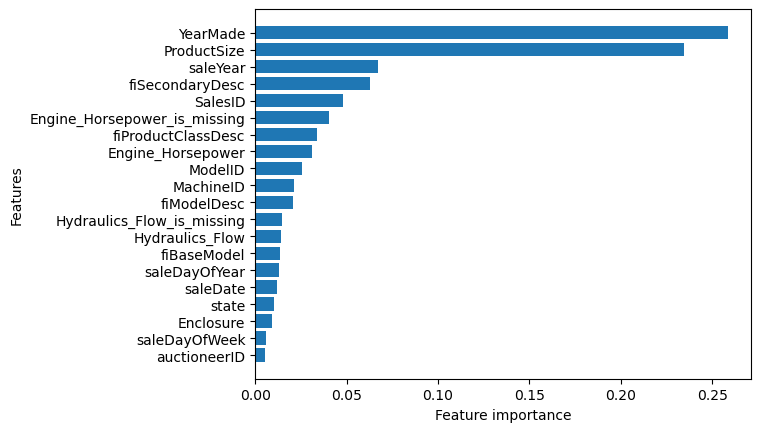

In [26]:
plot_features(X_train.columns, model.feature_importances_)

In [27]:
len(model.feature_importances_)

100

It looks like feature importance drops off pretty quickly.  Let's get a sense of which features account for 95% of importance.

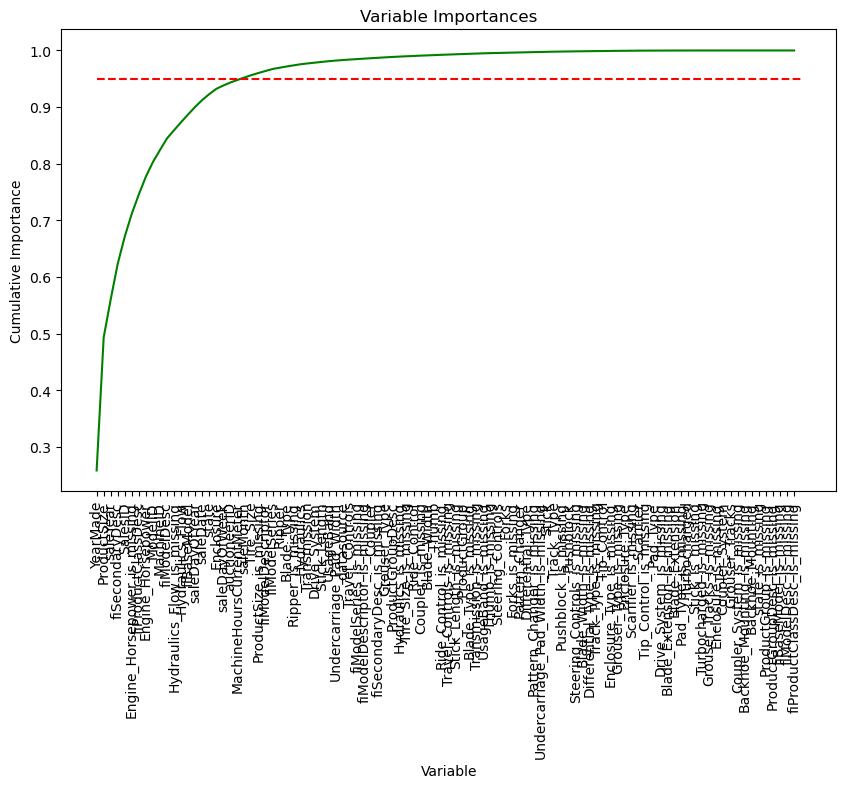

In [28]:
# Get feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Cumulative importances
cumulative_importances = np.cumsum(importances[indices])

# Make a line graph
plt.figure(figsize=(10, 6))
plt.plot(range(X_train.shape[1]), cumulative_importances, 'g-')
plt.hlines(y = 0.95, xmin=0, xmax=X_train.shape[1], color = 'r', linestyles = 'dashed')
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Variable Importances')

plt.show()

It looks like quite a few of these features are not included in that 95%.

Let's get a list of those features:

In [29]:
# Find index where cumulative importance exceeds 95%
# Add 1 because Python is zero-indexed
index_95 = np.where(cumulative_importances > 0.95)[0][0] + 1

# Get the names of unimportant features (those not contributing to 95% importance)
unimportant_feature_names = names[index_95:]

# Now unimportant_feature_names contains the names of the features that are not
# within the top 95% cumulative importance. You can print them out:
print("Features not contributing to 95% importance:")
for feature in unimportant_feature_names:
    print(feature)

Features not contributing to 95% importance:
Tire_Size
ProductSize_is_missing
fiModelDescriptor
fiModelSeries
Ripper
Blade_Type
Ripper_is_missing
Hydraulics
Transmission
Drive_System
Stick_Length
UsageBand
Undercarriage_Pad_Width
datasource
Travel_Controls
fiModelSeries_is_missing
fiModelDescriptor_is_missing
Coupler
fiSecondaryDesc_is_missing
Grouser_Type
ProductGroupDesc
Hydraulics_is_missing
Tire_Size_is_missing
Ride_Control
Coupler_is_missing
Blade_Width
Thumb
Ride_Control_is_missing
Travel_Controls_is_missing
Stick_Length_is_missing
ProductGroup
Blade_Type_is_missing
Transmission_is_missing
UsageBand_is_missing
Thumb_is_missing
Steering_Controls
Forks
Forks_is_missing
Pattern_Changer
Differential_Type
Pattern_Changer_is_missing
Undercarriage_Pad_Width_is_missing
Stick
Track_Type
Pushblock_is_missing
Pushblock
Steering_Controls_is_missing
Blade_Width_is_missing
Differential_Type_is_missing
Track_Type_is_missing
Tip_Control
Enclosure_Type_is_missing
Grouser_Type_is_missing
Enclosure

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372915 entries, 0 to 372914
Columns: 101 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(44), float64(3), int16(4), int64(10), int8(40)
memory usage: 69.7 MB


### Drop unimportant features

As fewer features means less computation, a tradeoff we should entertain is dropping the unimportant features so that we can have a more exhaustive gridsearch for hyperparameter tuning.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['SalePrice', *unimportant_feature_names]), 
    df.SalePrice,
    random_state=42
)

## Hyperparameter tuning with RandomizedSearchCV

Let's do a preliminary cross-validation using Randomized Search CV, so we can get a sense of where the ideal parameters are.

In [32]:
%%time
param_grid = {
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": [0.5, 1, 'sqrt']
}

rs_model = RandomizedSearchCV(
    RandomForestRegressor(
        n_jobs=-1,
        random_state=42,
    ),
    param_distributions=param_grid,
    scoring='neg_mean_absolute_error',
    n_iter=70, # increase for greater accuracy
    cv=5,
    verbose=True
)

# rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
CPU times: user 5min 47s, sys: 1min, total: 6min 47s
Wall time: 16min 35s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=70,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   scoring='neg_mean_absolute_error', verbose=True)

In [33]:
# save the model
models_dir = '../models/'
filename = 'rf-regressor.joblib'
dump_dir = f"{models_dir}{filename}"
# dump(rs_model, dump_dir)

['../models/rf-regressor.joblib']

In [34]:
# load the model
rs_model = load(dump_dir)

In [35]:
show_scores(rs_model)

{'Training...MAE': 2672.3028355081906,
 'Test.......MAE': 4481.802841827238,
 'Training...MSE': 18542561.463251058,
 'Test.......MSE': 49735635.77544791,
 'Training...RMLSE': 0.12762288835433264,
 'Test.......RMLSE': 0.20560945524703272,
 'Training...R2': 0.9665610075121479,
 'Test.......R2': 0.9096895332049417}

### Hyperparameter tuning with BayesianOptimization

In [36]:
# Define the function we want to optimize
def rf_cv(n_estimators, min_samples_split, max_features, max_depth):
    # As BayesianOptimization will pass float numbers, we need to round and convert to integer.
    rf = RandomForestRegressor(
        n_estimators=int(n_estimators),
        min_samples_split=int(min_samples_split),
        max_features=min(max_features, 0.999),  # for float
        max_depth=int(max_depth),
        n_jobs=-1
    )
    val = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
    return val

In [37]:
# Define the bounds of the hyperparameters we want to optimize
pbounds = {
    'n_estimators': (10, 250),
    'min_samples_split': (2, 25),
    'max_features': (0.1, 0.999),
    'max_depth': (5, 30)
}

In [38]:
optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=pbounds,
    random_state=42,
)

In [39]:
# Run optimization 
# optimizer.maximize(
#     init_points=5,  # Number of randomly chosen points to sample the target function before Bayesian optimization.
#     n_iter=20,  # Number of iterations where the Gaussian process chooses new points.
# )

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -5.211e+0 | 14.36     | 0.9547    | 18.84     | 153.7     |
| 2         | -8.944e+0 | 8.9       | 0.2402    | 3.336     | 217.9     |
| 3         | -4.577e+0 | 20.03     | 0.7366    | 2.473     | 242.8     |
| 4         | -4.776e+0 | 25.81     | 0.2909    | 6.182     | 54.02     |
| 5         | -5.885e+0 | 12.61     | 0.5718    | 11.93     | 79.89     |
| 6         | -4.576e+0 | 26.23     | 0.6542    | 6.29      | 52.53     |
| 7         | -4.629e+0 | 30.0      | 0.999     | 6.591     | 35.51     |
| 8         | -4.785e+0 | 30.0      | 0.999     | 24.55     | 44.98     |
| 9         | -6.928e+0 | 9.563     | 0.999     | 11.04     | 39.27     |
| 10        | -4.644e+0 | 30.0      | 0.999     | 13.17     | 250.0     |
| 11        | -6.007e+0 | 11.43     | 0.999     | 18.25     | 250.0     |
| 12        | -4.834e+0 | 30.0      | 

In [40]:
print(optimizer.max)

{'target': -4535.426243723634, 'params': {'max_depth': 30.0, 'max_features': 0.999, 'min_samples_split': 2.0, 'n_estimators': 250.0}}


In [41]:
optimizer.max['params']

{'max_depth': 30.0,
 'max_features': 0.999,
 'min_samples_split': 2.0,
 'n_estimators': 250.0}

In [42]:
best_params = {
    'max_depth': int(optimizer.max['params']['max_depth']), # must convert to int
    'max_features': 0.900037995011649,
    'min_samples_split': int(optimizer.max['params']['min_samples_split']),
    'n_estimators': int(optimizer.max['params']['n_estimators'])
}
best_params

{'max_depth': 30,
 'max_features': 0.900037995011649,
 'min_samples_split': 2,
 'n_estimators': 250}

In [43]:
bo_model = RandomForestRegressor(**best_params)

In [44]:
# bo_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, max_features=0.900037995011649,
                      n_estimators=250)

In [45]:
filename = 'bayesian-optimized-regressor.joblib'
dump_dir = f"{models_dir}{filename}"
# dump(bo_model, dump_dir)

['../models/bayesian-optimized-regressor.joblib']

In [46]:
bo_model = load(dump_dir)

In [47]:
show_scores(bo_model)

{'Training...MAE': 1639.5948350684127,
 'Test.......MAE': 4364.200469238181,
 'Training...MSE': 6730759.531112538,
 'Test.......MSE': 48115859.182510115,
 'Training...RMLSE': 0.08136847992294637,
 'Test.......RMLSE': 0.20314577004595255,
 'Training...R2': 0.9878619888711454,
 'Test.......R2': 0.9126307398052228}

### Pipeline Optimization with TPOT

The Tree-Based Pipeline Optimization Tool (TPOT) is a popular automated machine learning tool that automatically builds and optimizes machine learning pipelines using genetic programming. The TPOTRegressor is specifically tailored for regression tasks. 

http://epistasislab.github.io/tpot/

In [51]:
%time
pipeline_optimizer = TPOTRegressor(
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=KFold(n_splits=5),
    random_state=42,    
    generations=3,
    population_size=50,
    verbosity=2
)
# pipeline_optimizer.fit(X_train, y_train)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 11 µs


Optimization Progress:   0%|          | 0/200 [00:00<?, ?pipeline/s]

/Users/gregmckenzie/anaconda3/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/Users/gregmckenzie/anaconda3/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/Users/gregmckenzie/anaconda3/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/Users/gregmckenzie/anaconda3/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: opti


Generation 1 - Current best internal CV score: -5365.565309200581


/Users/gregmckenzie/anaconda3/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/Users/gregmckenzie/anaconda3/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/Users/gregmckenzie/anaconda3/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/Users/gregmckenzie/anaconda3/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: opti


Generation 2 - Current best internal CV score: -4812.361798802498


/Users/gregmckenzie/anaconda3/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/Users/gregmckenzie/anaconda3/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")



Generation 3 - Current best internal CV score: -4812.361798802498

Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=10, min_child_weight=14, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.25, verbosity=0)


TPOTRegressor(cv=KFold(n_splits=5, random_state=None, shuffle=False),
              generations=3, n_jobs=-1, population_size=50, random_state=42,
              scoring='neg_mean_absolute_error', verbosity=2)

In [52]:
# save exported pipeline
# pipeline_optimizer.export('tpot_exported_pipeline.py')

In [54]:
# import saved pipeline
from tpot_exported_pipeline import exported_pipeline
# fit the pipeline
exported_pipeline.fit(X_train, y_train)
# show scores
show_scores(exported_pipeline)

{'Training...MAE': 4411.909914273493,
 'Test.......MAE': 4727.795474953852,
 'Training...MSE': 45124750.30912358,
 'Test.......MSE': 53141288.268833235,
 'Training...RMLSE': 0.20274550137074715,
 'Test.......RMLSE': 0.2167150492605207,
 'Training...R2': 0.9186236384011195,
 'Test.......R2': 0.9035055152141389}

### Comparing models

In [68]:
scores = {
    'RandomSearch CV': show_scores(rs_model),
    'Bayesian Optimization': show_scores(bo_model),
    'TPOT Pipeline': show_scores(exported_pipeline)
}

In [61]:
# Convert the dictionary to DataFrame
data = []
for model, metrics in scores.items():
    for metric, score in metrics.items():
        metric_type, metric_name = metric.split(' ')
        data.append({
            'Model': model,
            'Metric': metric_name,
            'Type': metric_type,
            'Score': score
        })
df = pd.DataFrame(data)

In [63]:
def plot_metric(metric):
    g = sns.catplot(
    data=df[df['Metric'] == metric],
    x='Model',
    y='Score',
    hue='Type',
    kind='bar',
    height=5,
    aspect=2
    )
    g.set_axis_labels("", metric)
    g.set_titles("{col_name} {col_var}")
    g.despine(left=True)
    g.set(ylim=(0, None))
    plt.title(f"Comparison of {metric} between Models")
    plt.show()

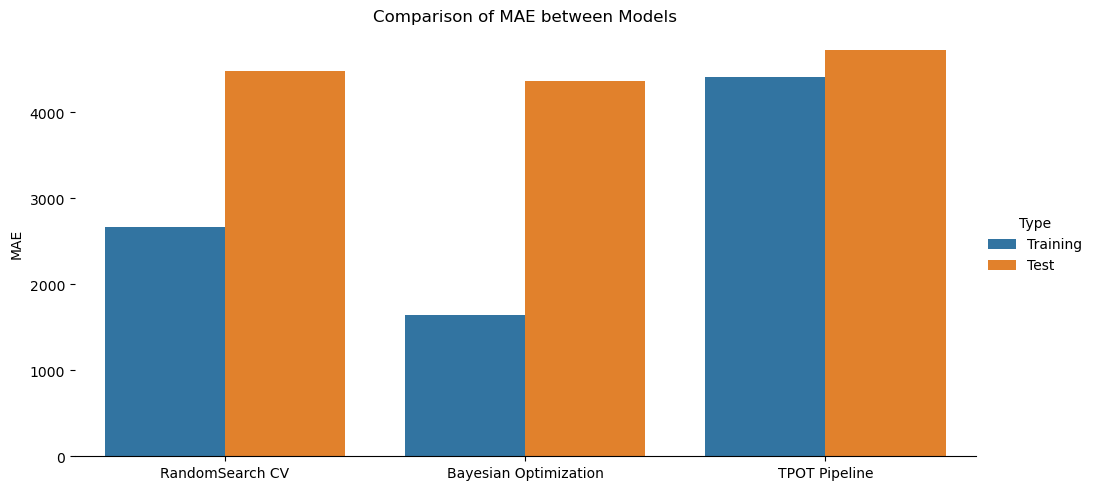

In [69]:
plot_metric('MAE')

#### Mean Absolute Error
Although there may be some risk in overfitting, it appears Bayesian Optimization has returned the smallest (most ideal) metrics, with RandomSearch CV and TPOT trailing behind.

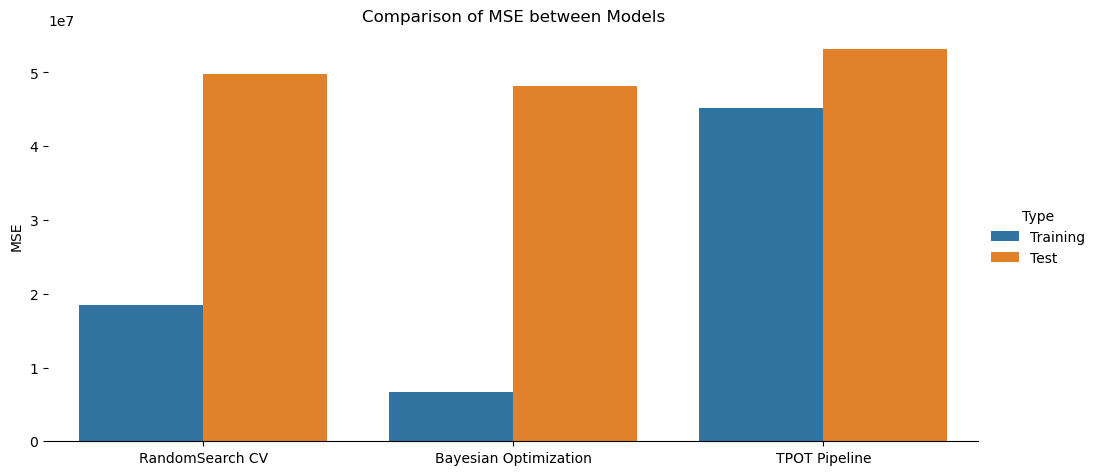

In [70]:
plot_metric('MSE')

#### Mean Squared Error
Although, looking at the Test scores, as opposed to the Training scores, Bayesian Optimization and RandomSearch CV are very close, Bayesian Optimization has a slightly smaller error score in this respect.

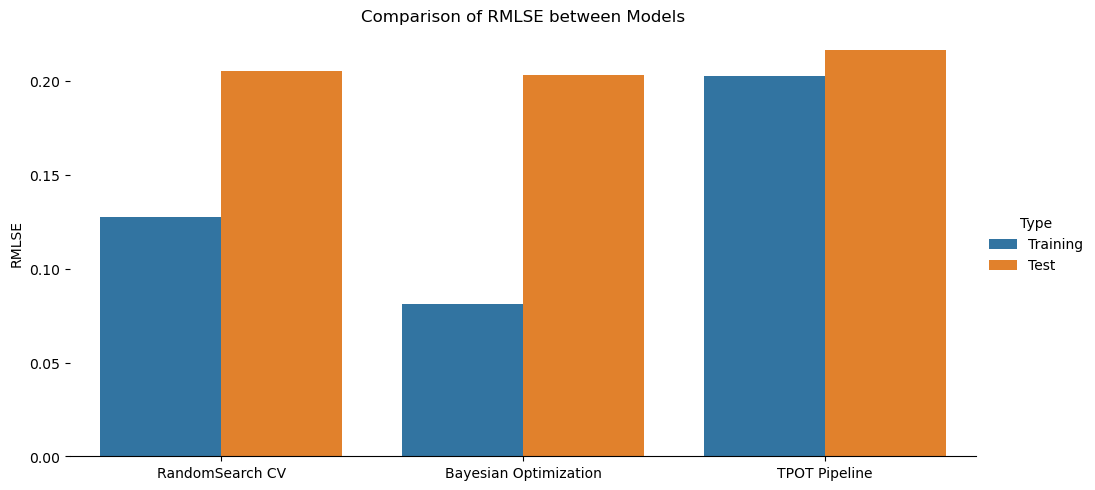

In [71]:
plot_metric('RMLSE')

#### Root Mean Squared Logarithmic Error
Again, looking at the Test scores, as opposed to the Training scores, Bayesian Optimization and RandomSearch CV are very close, Bayesian Optimization has a slightly smaller error score in this respect.

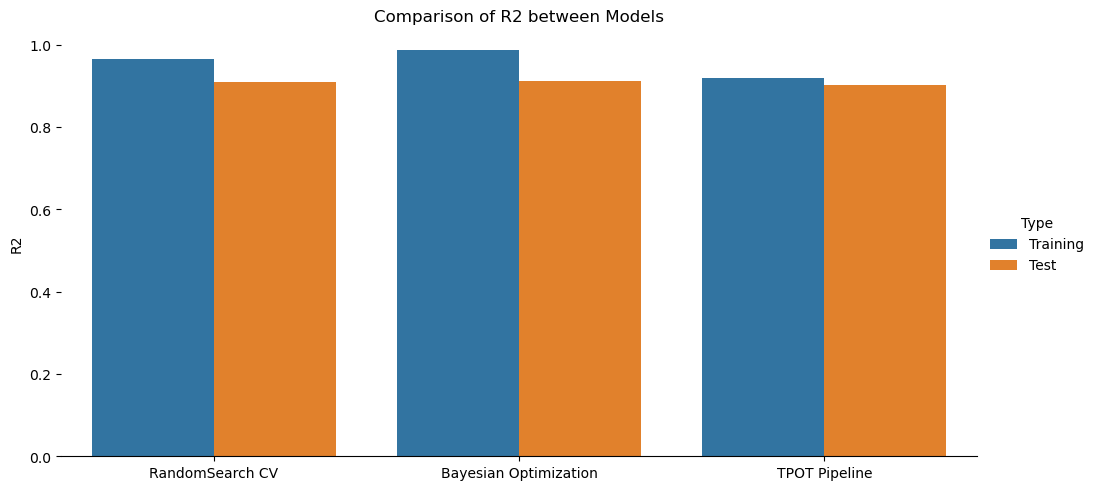

In [72]:
plot_metric('R2')

#### R2
These test scores are incredibly close.  TPOT looks appealing, as it appears to have the least evidence of overfitting

### Conclusions
In reviewing how these models compare between four different metrics, it appears our RandomForestRegressor model, with hyperparameters tuned via Bayesian Optimization, has returned the most competitive scoring metrics -- not just on our chosen metric, Mean Absoulute Error